Submitted by:
    Gursanjam Kaur (C0788089)

In [1]:
# Importing libraries
import tweepy as tw
import pandas as pd
import time
import os.path

## 1. Connecting to twitter

In [2]:
# Secret keys
consumer_key="phqNgX3Yvlk1DbS1GUQhgeTRW"
consumer_secret="CHn6y9RGrBuAbYvpYDVyOtNglMr7eSRHmrZQGu6osC8Dhje7x8"
access_token="1356231156853846017-SIv5svY0WkgIEJWKOyzU8Ismmnbfa4"
access_token_secret="ZRSfzbMI5DpFXRq8YY3SCd2q0GBqloPIUikrn1jMT59hr"

In [3]:
# Authenticating
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True )

## 2. Collecting data

In [4]:
# Collect the tweets from given timeline
def collect_data(user_name,count=1000):
    tweet_df = pd.DataFrame(columns=['username', 'location','tweet'])
    tweet_dict = dict()
    
    tweets = tw.Cursor(api.user_timeline,id=user_name,
                           include_rts = False, exclude_replies=True,
                           tweet_mode='extended').items(count)
    for tweet in tweets:
        tweet_dict['username'] = tweet.user.screen_name
        tweet_dict['location'] = tweet.user.location
        tweet_dict['tweet'] = tweet.full_text
        tweet_df = tweet_df.append(tweet_dict, ignore_index=True)
    
    return tweet_df

In [5]:
# Collect tweet from disney
tweet_df = collect_data('@disney',2500)
# Take backup
source_df = tweet_df.copy()
tweet_df.to_csv('disney.csv',index=False)

## 3. Data Preprocessing

### Data Cleaning

In [6]:
# Importing libraries
from bs4 import BeautifulSoup
import contractions
import re

In [7]:
# remove link
def remove_links(text):
    text = re.sub(r'https?:\/\/.*[ ]*', '', text)
    return text

# remove numbers
def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)


# remove space,newlines
def remove_slash(text):
    return re.sub(r'[\n,\b,\t]', '', text)

# remove HTML tag
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")
    return text

# remove contractions
def remove_contractions(text):
    return contractions.fix(text)

# remove non-alpha
def remove_nonalpha(text):
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub(r'_', '', text)
    return text

# remove space
def remove_space(text):
    return re.sub(r' +', ' ', text)

# lower case
def convert_lower(text):
    return text.lower()

In [8]:
# Clean the data
def clean_data(tweet_df):
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_html_tags)
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_numbers)
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_links)
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_slash)
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_contractions)
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_nonalpha)
    tweet_df['tweet'] = tweet_df['tweet'].apply(remove_space)
    tweet_df['tweet'] = tweet_df['tweet'].apply(convert_lower)
    
    return tweet_df

In [9]:
tweet_df = clean_data(tweet_df)

### Stop word removal and stemming

In [10]:
# Importing libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [11]:
# remove stop word
def remove_stop_words(text):

    removed_list = []

    for token in text.split():

        if token not in stopwords.words('english'):
            removed_list.append(token)

    return " ".join(removed_list)


# stemming
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in word_tokenize(text)]

In [12]:
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_stop_words)
tweet_df['tweet'] = tweet_df['tweet'].apply(stemming)

In [13]:
# Preprocess function
def preprocess(text):
    text = remove_html_tags(text)
    text = remove_numbers(text)
    text = remove_links(text)
    text = remove_slash(text)
    text = remove_contractions(text)
    text = remove_nonalpha(text)
    text = remove_space(text)
    text = convert_lower(text)
    text = remove_stop_words(text)
    text = stemming(text)
    
    return text

### Bag of Words on the Data set

In [14]:
#!pip install gensim

In [15]:
import gensim

C:\Users\ram\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [16]:
# Create a corpora dictonary
dictionary = gensim.corpora.Dictionary(tweet_df['tweet'])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 blunt
1 catch
2 co
3 could
4 disneyland
5 dwayn
6 emili
7 fan
8 fellow
9 jack
10 johnson


In [17]:
# filter the extremes
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [18]:
# create bow corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in tweet_df['tweet']]
bow_corpus[10]

[(6, 1), (24, 1), (32, 1), (39, 1)]

In [19]:
# Printing the words and occurance from bow
bow_doc_10 = bow_corpus[10]
for i in range(len(bow_doc_10)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_10[i][0], 
                                               dictionary[bow_doc_10[i][0]], 
bow_doc_10[i][1]))

Word 6 ("disneyplu") appears 1 time.
Word 24 ("new") appears 1 time.
Word 32 ("stream") appears 1 time.
Word 39 ("episod") appears 1 time.


### Td-Idf

In [20]:
from gensim import corpora, models

# Create a Tf-Idf model from BOW
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5739877616104178), (1, 0.5739877616104178), (2, 0.5840172078311774)]


## 3. LDA

### LDA using BOW

In [21]:
# LDA model using BOW
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)

In [22]:
# Print the topics and weightage
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.101*"disneyplu" + 0.087*"stream" + 0.083*"episod" + 0.052*"marvel" + 0.048*"studio" + 0.043*"loki" + 0.042*"marvelstudio" + 0.038*"start" + 0.038*"new" + 0.034*"seri"
Topic: 1 
Words: 0.081*"experi" + 0.071*"disneyplu" + 0.063*"studio" + 0.060*"marvel" + 0.056*"theater" + 0.048*"stream" + 0.033*"marvelstudio" + 0.030*"new" + 0.029*"order" + 0.028*"start"
Topic: 2 
Words: 0.050*"art" + 0.049*"disney" + 0.049*"theater" + 0.045*"access" + 0.045*"premier" + 0.041*"see" + 0.039*"disneyplu" + 0.039*"magic" + 0.038*"time" + 0.033*"dragon"
Topic: 3 
Words: 0.163*"make" + 0.089*"look" + 0.053*"disney" + 0.043*"magic" + 0.032*"everi" + 0.031*"film" + 0.030*"disneydecad" + 0.028*"scene" + 0.027*"art" + 0.025*"stream"
Topic: 4 
Words: 0.085*"magic" + 0.076*"celebr" + 0.059*"new" + 0.048*"disneyplu" + 0.040*"world" + 0.036*"stream" + 0.034*"studio" + 0.033*"trailer" + 0.030*"go" + 0.028*"marvel"
Topic: 5 
Words: 0.123*"disneyplu" + 0.106*"stream" + 0.075*"origin" + 0.072*"seri" +

### Using TD-IDF

In [23]:
# LDA model using td-idf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.073*"disneydecad" + 0.053*"seri" + 0.050*"time" + 0.050*"marvelstudio" + 0.049*"stream" + 0.047*"disneyplu" + 0.043*"origin" + 0.029*"start" + 0.025*"wandavis" + 0.024*"falconandwintersoldi"
Topic: 1 Word: 0.038*"theater" + 0.037*"cruella" + 0.034*"disney" + 0.034*"go" + 0.032*"fee" + 0.032*"addit" + 0.032*"requir" + 0.031*"brand" + 0.031*"meet" + 0.029*"access"
Topic: 2 Word: 0.104*"one" + 0.086*"celebr" + 0.044*"art" + 0.043*"best" + 0.040*"raya" + 0.039*"pixarsoul" + 0.038*"learn" + 0.037*"last" + 0.036*"order" + 0.033*"scene"
Topic: 3 Word: 0.056*"episod" + 0.048*"studio" + 0.044*"start" + 0.043*"seri" + 0.043*"loki" + 0.042*"stream" + 0.041*"disneyplu" + 0.041*"origin" + 0.039*"marvel" + 0.033*"us"
Topic: 4 Word: 0.063*"short" + 0.062*"film" + 0.061*"best" + 0.059*"life" + 0.043*"pixarluca" + 0.040*"origin" + 0.039*"new" + 0.038*"stream" + 0.037*"trailer" + 0.036*"watch"
Topic: 5 Word: 0.116*"anniversari" + 0.090*"happi" + 0.070*"pixar" + 0.055*"th" + 0.047*"celeb

## 4. Performance evaluation

In [24]:
# Printing the words of 11th tweet
tweet_df['tweet'][10]

['enrol',
 'mike',
 'comedi',
 'class',
 'yet',
 'funni',
 'scari',
 'stream',
 'new',
 'episod',
 'monstersatwork',
 'disneyplu']

### BOW

In [25]:
# Printing the related topic and its score using BOW model
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8133326172828674	 
Topic: 0.101*"disneyplu" + 0.087*"stream" + 0.083*"episod" + 0.052*"marvel" + 0.048*"studio" + 0.043*"loki" + 0.042*"marvelstudio" + 0.038*"start" + 0.038*"new" + 0.034*"seri"

Score: 0.013333403505384922	 
Topic: 0.136*"disneyplu" + 0.128*"stream" + 0.048*"film" + 0.044*"new" + 0.042*"stori" + 0.040*"pixar" + 0.030*"pixarluca" + 0.027*"short" + 0.027*"get" + 0.022*"season"

Score: 0.013333401642739773	 
Topic: 0.120*"disney" + 0.092*"disneyplu" + 0.091*"new" + 0.084*"stream" + 0.045*"check" + 0.035*"brand" + 0.029*"look" + 0.025*"like" + 0.025*"start" + 0.021*"pixarsoul"

Score: 0.0133333969861269	 
Topic: 0.100*"stream" + 0.098*"watch" + 0.087*"disneyplu" + 0.071*"pixarluca" + 0.065*"new" + 0.057*"trailer" + 0.048*"summer" + 0.034*"june" + 0.033*"start" + 0.029*"brand"

Score: 0.013333392329514027	 
Topic: 0.112*"come" + 0.090*"disneyplu" + 0.072*"new" + 0.045*"stream" + 0.045*"littl" + 0.034*"cruella" + 0.033*"may" + 0.029*"adventur" + 0.028*"origin" + 0

### TD-IDF

In [26]:
# Printing the related topic and its score using Td-Idf model
for index, score in sorted(lda_model_tfidf[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8133324384689331	 
Topic: 0.056*"episod" + 0.048*"studio" + 0.044*"start" + 0.043*"seri" + 0.043*"loki" + 0.042*"stream" + 0.041*"disneyplu" + 0.041*"origin" + 0.039*"marvel" + 0.033*"us"

Score: 0.013333426788449287	 
Topic: 0.059*"stream" + 0.053*"disneyplu" + 0.051*"watch" + 0.047*"episod" + 0.030*"marvelstudio" + 0.030*"pixarluca" + 0.030*"two" + 0.028*"start" + 0.028*"trailer" + 0.027*"soldier"

Score: 0.013333424925804138	 
Topic: 0.098*"season" + 0.080*"new" + 0.069*"get" + 0.055*"year" + 0.050*"stream" + 0.047*"cast" + 0.041*"disneyplu" + 0.041*"readi" + 0.034*"magic" + 0.026*"may"

Score: 0.01333340723067522	 
Topic: 0.073*"disneydecad" + 0.053*"seri" + 0.050*"time" + 0.050*"marvelstudio" + 0.049*"stream" + 0.047*"disneyplu" + 0.043*"origin" + 0.029*"start" + 0.025*"wandavis" + 0.024*"falconandwintersoldi"

Score: 0.013333404436707497	 
Topic: 0.063*"short" + 0.062*"film" + 0.061*"best" + 0.059*"life" + 0.043*"pixarluca" + 0.040*"origin" + 0.039*"new" + 0.038*"stream

### Unseen document

In [27]:
# Testing on unseen document
unseen_document = 'How many of you are waiting to watch the suicide squad movie in theatre'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
# BOW model
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.3701731562614441	 Topic: 0.096*"disneydecad" + 0.083*"disneyplu" + 0.075*"stream" + 0.057*"new" + 0.040*"time"
Score: 0.34093502163887024	 Topic: 0.100*"stream" + 0.098*"watch" + 0.087*"disneyplu" + 0.071*"pixarluca" + 0.065*"new"
Score: 0.02222250960767269	 Topic: 0.050*"art" + 0.049*"disney" + 0.049*"theater" + 0.045*"access" + 0.045*"premier"
Score: 0.022222494706511497	 Topic: 0.079*"miss" + 0.070*"disneyplu" + 0.052*"stream" + 0.050*"pixar" + 0.047*"cast"
Score: 0.02222249284386635	 Topic: 0.088*"new" + 0.060*"disney" + 0.043*"disneyplu" + 0.037*"year" + 0.034*"disneyland"
Score: 0.022222472354769707	 Topic: 0.073*"order" + 0.061*"premier" + 0.060*"access" + 0.058*"theater" + 0.054*"see"
Score: 0.02222244255244732	 Topic: 0.085*"magic" + 0.076*"celebr" + 0.059*"new" + 0.048*"disneyplu" + 0.040*"world"
Score: 0.022222435101866722	 Topic: 0.081*"experi" + 0.071*"disneyplu" + 0.063*"studio" + 0.060*"marvel" + 0.056*"theater"
Score: 0.022222433239221573	 Topic: 0.163*"make" +

## 5. World Cloud

In [28]:
#!pip install wordcloud

In [29]:
# Import libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [30]:
# Display word cloud
def word_cloud(model):
    topics = lda_model.show_topics(num_topics=15, num_words=10,formatted=False)
    
    top_10_topic = ''
    for topic in topics:
        for i in topic[1]:
            top_10_topic = top_10_topic + " " + i[0]
            
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=1000).generate(top_10_topic)
    plt.imshow(wordcloud)
    plt.show()

### BOW

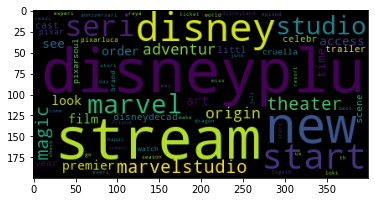

In [31]:
# Word cloud - BOW
word_cloud(lda_model)

### TD-IDF

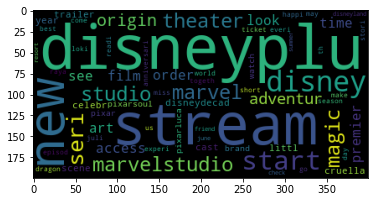

In [32]:
# Word cloud - Tf-Idf
word_cloud(lda_model_tfidf)

## 6. Related tweets

In [33]:
# Searching tweets for given word
def search_words(word):
    copy_df = tweet_df.copy()
    copy_df['tweet'] = copy_df['tweet'].apply(lambda x: ' '.join(map(str, x)))
    found_tweets = copy_df[copy_df['tweet'].str.contains(word)]

    for idx, tweet in found_tweets.iterrows():
        print(source_df.iloc[idx]['tweet'])
        print('\n')

In [34]:
# Input the word
word = input('Word to search\n')
search_words(word)

Word to search
stream
#Hawkeye never misses 🏹  Don’t miss @JeremyRenner and @HaileeSteinfeld in this exclusive first-look of @MarvelStudios’ Hawkeye. The Original Series starts streaming Wednesday, November 24 on @DisneyPlus. https://t.co/KyvJAcgE5t


Have you enrolled in Mike’s Comedy Class yet? He's so funny, it's scary! Stream new episodes of #MonstersAtWork now on #DisneyPlus. https://t.co/nABfdARTOd


Join The Watcher in pondering the question #WhatIf in @MarvelStudios' first animated series, streaming August 11 on @DisneyPlus. https://t.co/IFMmca3uhF


“I’ve never done anything like this before.” Happier Than Ever: A Love Letter to Los Angeles – A @BillieEilish Concert Experience is streaming September 3 on @DisneyPlus. #BillieEilishOnDisneyPlus with Gustavo Dudamel and the LA Phil at the Hollywood Bowl. https://t.co/Zkqef8vySO


Self-reflection. Growth. Power. Happier Than Ever: A Love Letter to Los Angeles – A @BillieEilish Concert Experience is streaming September 3 on @Disney

## 7. Bar diagram

### BOW

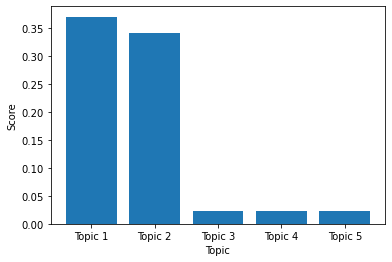

Topic 1:
0.096*"disneydecad" + 0.083*"disneyplu" + 0.075*"stream" + 0.057*"new" + 0.040*"time"
Topic 2:
0.100*"stream" + 0.098*"watch" + 0.087*"disneyplu" + 0.071*"pixarluca" + 0.065*"new"
Topic 3:
0.050*"art" + 0.049*"disney" + 0.049*"theater" + 0.045*"access" + 0.045*"premier"
Topic 4:
0.079*"miss" + 0.070*"disneyplu" + 0.052*"stream" + 0.050*"pixar" + 0.047*"cast"
Topic 5:
0.088*"new" + 0.060*"disney" + 0.043*"disneyplu" + 0.037*"year" + 0.034*"disneyland"


In [35]:
# Top 5 topics for given document - BOW
top5_df = pd.DataFrame(columns=['Score', 'Topic'])
top5_dict = dict()


unseen_document = 'How many of you are waiting to watch the suicide squad movie in theatre'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[:5]:
    top5_dict['Score'] = score
    top5_dict['Topic'] = lda_model.print_topic(index, 5)
    
    top5_df = top5_df.append(top5_dict, ignore_index=True)

plt.bar(range(5), top5_df['Score'])
plt.xticks(range(5), ['Topic ' + str(i+1) for i in range(5)] )
plt.xlabel('Topic')
plt.ylabel('Score')
plt.show()

for i in range(5):
    print('Topic ' + str(i+1) + ':')
    print(top5_df.iloc[i]['Topic'])

### TD-IDF

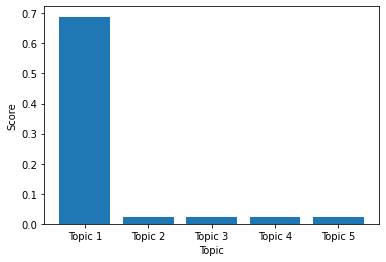

Topic 1:
0.063*"short" + 0.062*"film" + 0.061*"best" + 0.059*"life" + 0.043*"pixarluca"
Topic 2:
0.059*"stream" + 0.053*"disneyplu" + 0.051*"watch" + 0.047*"episod" + 0.030*"marvelstudio"
Topic 3:
0.079*"learn" + 0.061*"stori" + 0.057*"raya" + 0.056*"last" + 0.054*"dragon"
Topic 4:
0.064*"make" + 0.052*"moment" + 0.051*"experi" + 0.048*"miss" + 0.031*"pixarsoul"
Topic 5:
0.038*"theater" + 0.037*"cruella" + 0.034*"disney" + 0.034*"go" + 0.032*"fee"


In [36]:
# Top 5 topics for given document - Td-Idf
top5_df = pd.DataFrame(columns=['Score', 'Topic'])
top5_dict = dict()


unseen_document = 'How many of you are waiting to watch the suicide squad movie in theatre'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1])[:5]:
    top5_dict['Score'] = score
    top5_dict['Topic'] = lda_model_tfidf.print_topic(index, 5)
    
    top5_df = top5_df.append(top5_dict, ignore_index=True)

plt.bar(range(5), top5_df['Score'])
plt.xticks(range(5), ['Topic ' + str(i+1) for i in range(5)] )
plt.xlabel('Topic')
plt.ylabel('Score')
plt.show()

for i in range(5):
    print('Topic ' + str(i+1) + ':')
    print(top5_df.iloc[i]['Topic'])